<a href="https://colab.research.google.com/github/SIDDXSingh/AutoEncoders/blob/main/VAE_Cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt  # for plotting images
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import time
import os
import torchvision
from torchvision import transforms
from torchvision import transforms,datasets,models

In [ ]:
import ipywidgets as widgets
widgets.IntSlider()

IntSlider(value=0)

In [ ]:
torch.cuda.device(0)
torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

In [ ]:
train_set = datasets.CIFAR10('/content/', train=True, download=True)
test_set = datasets.CIFAR10('/content/', train=False, download=False)


Extracting /content/cifar-10-python.tar.gz to /content/


In [ ]:
train_img = train_set.data
test_img = test_set.data
# rgb_batch = np.repeat(grayscale_batch[..., train_img], 3, -1)
train_img.shape

(50000, 32, 32, 3)

In [ ]:

batch_size = 500
train_images = torch.Tensor(train_img).permute(0,3,1,2)
test_images = torch.Tensor(test_img).permute(0,3,1,2)
train_images.shape


torch.Size([50000, 3, 32, 32])

In [ ]:
def variational_loss(output,X_in,mean,std):
    loss_function = nn.MSELoss()
    #loss_function = nn.SmoothL1Loss(reduction='sum')
    rec_loss=loss_function(output,X_in)

    kl_loss= -(0.5/len(X_in))*torch.sum(1+torch.log(torch.pow(std,2)+1e-10)-torch.pow(std,2)-torch.pow(mean,2))
    total_loss=rec_loss+kl_loss

    return total_loss

In [ ]:
class EncoderBlock(nn.Module):
    
    def __init__(self, in_channels, out_channels, identity_downsample=None,  stride=1):
        
        super(EncoderBlock, self).__init__()
        
        self.expansion=4
        
        self.conv1=nn.Conv2d(in_channels, out_channels,kernel_size=3,stride=1,padding=1)
        self.bn1=nn.BatchNorm2d(out_channels)
        
        self.conv2=nn.Conv2d(out_channels, out_channels,kernel_size=3,stride=stride,padding=1)
        self.bn2=nn.BatchNorm2d(out_channels)


        self.relu=nn.ReLU()
        self.identity_downsample=identity_downsample
        self.stride=stride
        

    def forward(self, x):
        
        
        identity=x.clone()
        
        
        x=self.conv1(x)
        x=self.bn1(x)
        x=self.relu(x)
        x=self.conv2(x)
        x=self.bn2(x)
        x=self.relu(x)
        
        
        if self.identity_downsample is not None: 
            identity=self.identity_downsample(identity)
        x+=identity
        x=self.relu(x)
        
        return x
        
        
encode_block=EncoderBlock


class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels,stride=1,upsample=None,shape=None, padding=1):
        
        super(DecoderBlock, self).__init__()
        
        self.contract=4
        self.out_channels=out_channels
            
        self.trans1=nn.ConvTranspose2d(in_channels, out_channels, 3, 1, 1)
        self.bn1=nn.BatchNorm2d(out_channels)
            
        self.trans2=nn.ConvTranspose2d(out_channels, out_channels, 3, stride, padding)
        self.bn2=nn.BatchNorm2d(out_channels)
        
            
        self.relu=nn.ReLU()
        self.upsample = upsample
        
        self.stride=stride
        
        self.shape=shape
               
            
            
    def forward(self, x):
        identity=x.clone()
        #print("id",x.size())
        shape=self.shape
        if self.shape is not None:
            shape=[x.size()[0],self.out_channels,self.shape,self.shape]
        
        
        x=self.trans1(x)
        x=self.bn1(x)
        x=self.relu(x)
        
        x=self.trans2(x,shape)
        x=self.bn2(x)
        x=self.relu(x)
        
        if self.upsample is not None: 
            identity=self.upsample(identity,x.size())
            identity=self.bn2(identity)
            
        #print("id",identity.size())
        x+=identity
        x=self.relu(x)
        
        
        return x
    
decode_block=DecoderBlock



In [ ]:
class ResNet(nn.Module):
    def __init__(self, encode_block,layers,decode_block,decode_layers, img_channels, num_class):
        super(ResNet, self).__init__()
        
        self.in_channels=16
        
        self.layer= nn.Sequential(nn.Conv2d(img_channels, 16, kernel_size=3, stride=2, padding=1, bias=False),
                                  nn.BatchNorm2d(16),
                                  nn.ReLU(),
        )
        
        
        
        self.layer1 = self.make_layer(
            encode_block, layers[0], out_channels=64, stride=1
        )
        self.layer2 = self.make_layer(
            encode_block, layers[1], out_channels=256, stride=2
        )

        self.layer3 = self.make_layer(
            encode_block, layers[2], out_channels=512, stride=2
        )

        self.layer4 = self.make_layer(
            encode_block, layers[3], out_channels=2048, stride=2
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Flatten()
        
        
        
        self.decode_in_channels=1024
        self.decode_padding=1
        
        self.trans_layer1 = self.make_trans_layer(
            decode_block, decode_layers[0], out_channels=1024, shape=2, stride=2
        )
        self.trans_layer2 = self.make_trans_layer(
            decode_block, decode_layers[1], out_channels=512, shape=4, stride=2
        )
            
        self.trans_layer3 = self.make_trans_layer(
            decode_block, decode_layers[2], out_channels=256, shape=8, stride=2        
        )
        self.trans_layer4 = self.make_trans_layer(
            decode_block, decode_layers[3], out_channels=64, shape=16, stride=2
        )

        #self.trans_layer5 = self.make_trans_layer(
        #    decode_block, decode_layers[4], out_channels=12, shape=32, stride=2
        #)

        self.trans_layer5 = nn.ConvTranspose2d(64, out_channels=16,kernel_size=3, stride=1, padding=1)
        self.trans_layer6 = nn.ConvTranspose2d(16, out_channels=3,kernel_size=3, stride=2, padding=1)

    def forward(self, x):
        
        x=self.layer(x)
        x=self.layer1(x)
        x=self.layer2(x)
        x=self.layer3(x)
        x=self.layer4(x)
        x=self.avgpool(x)

        latent = self.fc(x)


        mean,std=torch.chunk(latent,2,dim=1)
        sample = mean + torch.randn_like(std)*std
        x=sample.view(sample.shape[0],1024,1,1)
        
        
        
        x=self.trans_layer1(x)
        x=self.trans_layer2(x)
        x=self.trans_layer3(x) 
        x=self.trans_layer4(x)
        x=self.trans_layer5(x)
        x=self.trans_layer6(x,[x.size(0),3,32,32])
        
        return x,mean, std
    
    def make_layer(self, encode_block, blocks, out_channels,stride=1):
        
        downsample = None
        layers = []
        
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    out_channels, 
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                    
                ),nn.BatchNorm2d(out_channels),)
            
  
        layers.append(encode_block(self.in_channels, out_channels, downsample, stride)
                     )
        
        
        self.in_channels = out_channels
        
        for i in range(1, blocks):
            layers.append(encode_block(self.in_channels, out_channels))
        return nn.Sequential(*layers)
    
    
    
    def make_trans_layer(self, decode_block, blocks, out_channels, shape=None, stride=1):
        
        upsample = None
        layers = []
        
        if stride != 1 or self.in_channels != out_channels/4:
            
            upsample = nn.ConvTranspose2d(self.decode_in_channels, out_channels,kernel_size=3,stride=2,bias=False,padding=1)
                                   
                                   
                                   
        layers.append(decode_block(self.decode_in_channels, out_channels, stride, upsample, shape,padding=self.decode_padding)
                     )
        
        
        self.decode_in_channels= out_channels
        
        for i in range(1, blocks):
            layers.append(decode_block(in_channels=self.decode_in_channels, out_channels=out_channels))
    
        return nn.Sequential(*layers)
    
    
    

In [ ]:
net=ResNet(encode_block,[2,2,2,2], decode_block, [2,2,2,2], 3, 10).to(device)

In [ ]:
w=torch.randn([2,3,32,32])
net(w.to(device))[0].size()

torch.Size([2, 3, 32, 32])

In [ ]:
def train(X):
    loss_list=[]
    for epoch in range(0,10):
        cost = 0
#         batch = torch.from_numpy(np.arange(0,X.shape[0],dtype="int64"))
#If you would like to check with arange instead of randperm, then uncomment above and comment below lines respectively
        batch=torch.randperm(X.shape[0]).to(device)
        for i in range(0, X.shape[0],batch_size):
            output,mean,std = net(X[batch[i:i+batch_size]].to(device))
            optimiser.zero_grad()
#             rev_fc=nn.ConvTranspose2d(3,1,2,1,0)
#             X=rev_fc(X)
            loss=variational_loss(output,X[batch[i:i+batch_size]].to(device),mean,std)
            cost = cost+loss.item() 
            loss.backward()
            optimiser.step()
        loss_avg = cost / X.shape[0]
        loss_list.append(loss_avg)
        print("For iteration: ", epoch+1, " the loss is :", loss_avg)
#         a=mean.detach().numpy()
#         plt.scatter(a[:,0],a[:,1])
#         break
    return loss_list

In [ ]:
optimiser = optim.Adam(net.parameters(), lr=0.0009)
net=net.to(device)

In [ ]:

import matplotlib.pyplot as plt
train_loss= train(train_images)


For iteration:  1  the loss is : 1.5824554467773437


In [ ]:
torch.cuda.empty_cache()
del train_loss

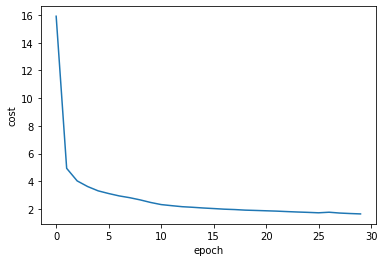

In [ ]:
plt.plot(train_loss)
plt.ylabel('cost')
plt.xlabel('epoch')
plt.show()

In [ ]:
def test(X):
    with torch.no_grad():
        cost=0
        batch=torch.randperm(X.shape[0])
        for i in range(0, X.shape[0],batch_size):
            output,mean,std=net(X[batch[i:i+batch_size]].to(device))
            loss=variational_loss(output,X[batch[i:i+batch_size]].to(device),mean,std)
            cost=cost+loss.item()
        print(cost/X.shape[0])
test(test_images)

1.6313292358398437


MNIST Image


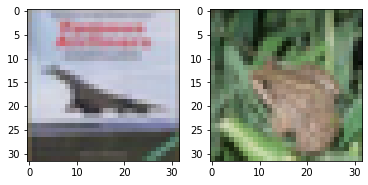

Image through Variational AutoEncoder
torch.Size([5, 3, 32, 32])


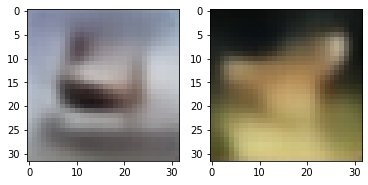

In [ ]:
print("MNIST Image")
fig, axes = plt.subplots(1,2)
axes[0].imshow(test_img[3])
axes[1].imshow(test_img[4])

plt.show()

print("Image through Variational AutoEncoder")
# print(test_images[1:45].shape)
output=net(test_images[:5].to(device))
print(output[0].size())
output_img=((output[0].to(torch.device('cpu'))).permute(0,2,3,1).detach().numpy())

fig, axes = plt.subplots(1,2)
axes[0].imshow(output_img[3].astype('uint8'))
axes[1].imshow(output_img[4].astype('uint8'))

plt.show()

In [ ]:
a=output_img[0].detach().type(torch.IntTensor) 

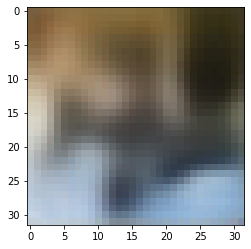

In [ ]:
plt.imshow(a)

In [ ]:
w=torch.randn([1,3,15,15])

In [ ]:
trans1=nn.ConvTranspose2d(3,3, 3, 1, 1) 

In [ ]:
w=trans1(w)

In [ ]:
w.size()

torch.Size([1, 3, 15, 15])